In [10]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import joblib
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline

In [11]:
TIMESTAMP = datetime.now().strftime("%d%m%Y%H%M%S")

In [12]:
# set working directory to project root
os.chdir("C:/Users/zacha/Documents/GitHub/plymouth-university-proj518")
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


In [13]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [14]:
def scaler():
    file = "data/NCEP daily velocity potential reanalysis.csv"
    df = pd.read_csv(file, sep=",")

    x = df[["Lon", "Lat", "Day"]]
    y = df[["Chi"]]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

    yscaler = StandardScaler()
    yscaler = yscaler.fit(y)

    # transform y_train and y_test to standardized scale
    y_train = yscaler.transform(y_train)
    y_test = yscaler.transform(y_test)

    scaler_path = os.path.join(
        os.getcwd(),
        "saved_models",
        f"wind_time_scaler_{TIMESTAMP}",
    )
    joblib.dump(yscaler, scaler_path)
    print("Saved scaler at %s " % scaler_path)

    # normalise X input type
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, y_train, x_test, y_test, yscaler

In [15]:
def build():
    model = Sequential()

    model.add(Dense(32, input_dim=3, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(512, activation="relu"))  # NEW
    model.add(Dense(1024, activation="relu"))  # NEW
    model.add(Dense(128, activation="relu"))  # NEW
    model.add(Dense(64, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="linear"))

    model.summary()

    model.compile(loss="mse", optimizer="adam", metrics=["rmse"]) #metrics=["mse", "mae"])

    return model

In [16]:
def train(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=150,
    batch_size=50,
    verbose=1,
    validation_split=0.2,
):

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        validation_split=validation_split,
    )

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    # save model and weights
    model_path = os.path.join(
        os.getcwd(),
        "saved_models",
        f"wind_time_regression_model_{TIMESTAMP}.h5",
    )
    model.save(model_path)
    print("Saved trained model at %s " % model_path)

    # score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print("Test loss:", scores[0])
    print("Test accuracy:", scores[1])

    return model

In [21]:
def test(model, yscaler, coords):
    regression = model.predict(coords)
    regression = yscaler.inverse_transform(
        regression
    )  # transform back to original scale

    regression = pd.DataFrame(regression, columns=["Chi"])
    regression = pd.concat([coords, regression], axis=1)

    print(regression)

Saved scaler at C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_time_scaler_25082022164000 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312   

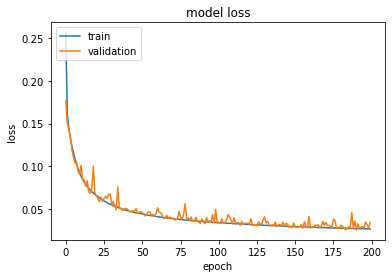

Saved trained model at C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_time_regression_model_25082022164000.h5 
12916/12916 [==============================] - 26s 2ms/step - loss: 0.0341 - mse: 0.0341 - mae: 0.1329
Test loss: 0.0340682677924633
Test accuracy: 0.0340682677924633
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [18]:
# build model
x_train, y_train, x_test, y_test, yscaler = scaler()
model = build()

# train model
model = train(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=200,  # test 1-5: 150, test 6: 200
    batch_size=1024,  # test 1-5: 50, test 6: 128
    verbose=1,
    validation_split=0.1,
)

# print model summary - architecture
model.summary()


In [22]:
# test model
test_coords = pd.DataFrame([[-37.814, 144.96332, 1], [-37.814, 144.96332, 103]])
test_coords.columns = ["Lon", "Lat", "Day"]
test(model, yscaler, coords=test_coords)

      Lon        Lat  Day           Chi
0 -37.814  144.96332    1 -5.142513e+06
1 -37.814  144.96332  103  1.716039e+05
